# Лекция 13: Dask DataFrame

__Автор: Сергей Вячеславович Макрушин__ e-mail: SVMakrushin@fa.ru 

Финансовый универсиет, 2020 г. 

При подготовке лекции использованы материалы:
* ...

V 0.3 25.11.2020

## Разделы: <a class="anchor" id="разделы"></a>
* [Серии (Series) - одномерные массивы в Pandas](#серии)
* [Датафрэйм (DataFrame) - двумерные массивы в Pandas](#датафрэйм)
    * [Введение](#датафрэйм-введение)
    * [Индексация](#датафрэйм-индексация)    
* [Обработка данных в библиотеке Pandas](#обработка-данных)
    * [Универсальные функции и выравнивание](#обработка-данных-универсальные)
    * [Работа с пустыми значениями](#обработка-данных-пустрые-значения)
    * [Агрегирование и группировка](#обработка-данных-агрегирование)    
* [Обработка нескольких наборов данных](#обработка-нескольких)
    * [Объединение наборов данных](#обработка-нескольких-объединение)
    * [GroupBy: разбиение, применение, объединение](#обработка-нескольких-групбай)
 
-

* [к оглавлению](#разделы)

In [1]:
# загружаем стиль для оформления презентации
from IPython.display import HTML
from urllib.request import urlopen
html = urlopen("file:./lec_v2.css")
HTML(html.read().decode('utf-8'))

## Ввведение в Dask DataFrame 

__Dask DataFrame__ это большой, предназначенный для параллельной обработки, DataFrame __состоящий из множества датафрэймов Pandas__. Датафрэймы, из которых соситит Dask DataFrame:
* редставляют собой фрагменты большого DataFrame, __разбитого по индексу__.
* __могут располагаться на диске__, для вычислений с данными, большими, чем оперативная память, как на одной машине, так и на разных машинах, входящих в кластер. 

Dask DataFrame имеет __интерфейс, максимально похожий на Pandas DataFrame__, при этом:
* одна операция с Dask DataFrame __порождает множество операций с датафрэймами Pandas__
* вычисления управляеются с помощью инфраструкутры Dask, которая позволяет:
    * распараллеливать рассчеты
    * выполнять рассчеты поэтапно, что дает возможность обрабатывать объемы данных, большие чем оператмивная память.

<center>         
    <img src="./img/dask-dataframe.svg" alt="Граф зависимостей задач" style="width: 150px;"/>
    <b>Dask DataFrame</b>
</center>

Каждый блок данных в разбиении называется __сегментом (partition)__ а его верхняя и нижняя граница __разделителем (division)__.
* Dask может хранить информацию о разделителях.
* Разбиение на сегменты важно для выполнения эффективных запросов.
* Сегменты станут важны при написании собственных функций, которые необходимо применить к элементам в Dask DataFrame.

__Мотивация__: Dask DataFrame целесообразно использовать для анализа и обработки данных:
* имеющих табличный формат 
* и имеющих размер больший, чем оперативная память. 
В частности, если операции с вашим массивом данных в Pandas приводят к ошибкам MemoryError, то использование Dask DataFrame позволяет обойти эту проблему.

__Издержки__:
* Операции Dask DataFrame используют вызовы функций pandas.
* Обычно они выполняются с той же скоростью что и операции в pandas.
* Небольшые дополнительные накладные расходы добавляет инфраструктура Dask (окло 1 мс. на задачу, при выполнении достаточно курпных задач этими издержками можно пренебречь). 

__Технология обеспечения паралелизма__:
* По умолчанию Dask DataFrame использует планировщик "multi-threaded". Этот планировщик демонстрирует параллелизм когда операции Pandas или используемого им NumPy освобождают GIL.
* В целом, в Pandas GIL освобождается реже, чем в NumPy. Поэтому ожидаемый прирост скорости от использования множества ядер для Dask DataFrame меньше, чем при использование Dask Array.
* Постепенно количество операций Pandas, освобождающих GIL увеличиывается, что будет положительно сказаываться на приросте производительности операций в Dask DataFrame.

__Использование альтернативного планировщика__:
* <em class="pl"></em> Планировщик задач "distributed" позволяет исполнять одно выражение с датафрэймом на всех узлах кластера (или всех ядрах одного компьютера) и не ограничен необходимостью освобождать GIL.
* <em class="mn"></em> Обратной стороной использования такого подхода является отказ от использования разделяемой памяти и, как следствие, накладные расходы на обмен данными.

* В частности, при __работе с текстовыми данными__ переход на планировщик "distributed" позволяет получить приращение производительности как на кластере, так и на одном компьютере.

Для эффективной обработки больших данных с помощью планировщика "distributed" рекомендуется:
* загружать данные методом `read_csv` из хранилища, доступного для каждого узла (например, такого как amazon S3)
* организовывать вычисления, так, чтобы они начинались с отбора данных для обработки, их фильтрации и преобразований и заврешались операциями, требующими обмена данными между узлами

* We call each chunk a partition, and the upper / lower bounds are divisions. Dask can store information about the divisions. We'll cover this in more detail in Distributed DataFrames. For now, partitions come up when you write custom functions to apply to Dask DataFrames

## Ограничения при работе с Dask DataFrame

Pandas обладает существенно большим функционалом, чем поддерживает Dask DataFrame. 

#### Какие функции не работают?

Dask DataFrame покрывает только небольшую но наиболее востребовыванную часть API pandas. Причинами такого положения являются, то, что:

* Pandas обладает гигантским API
* Некоторые операции по своей природе сложно выполнить параллельно (например, сортировку)

Кроме того, некоторые важные операции, такие как ``set_index`` работают, но существенно медленнее, чем в Pandas, так как по своей сути требуют группировки (shuffling) данных и могут потребовать записи данных на диск.

#### Какие функции определенно работают

* Тривиально распараллеливаемые операции (работают быстро):
    *  Elementwise operations:  ``df.x + df.y``
    *  Row-wise selections:  ``df[df.x > 0]``
    *  Loc:  ``df.loc[4.0:10.5]``
    *  Common aggregations:  ``df.x.max()``
    *  Is in:  ``df[df.x.isin([1, 2, 3])]``
    *  Datetime/string accessors:  ``df.timestamp.month``
* Операции, требующие нетривиальной организации параллельной работы (работают быстро):
    *  groupby-aggregate (with common aggregations): ``df.groupby(df.x).y.max()``
    *  value_counts:  ``df.x.value_counts``
    *  Drop duplicates:  ``df.x.drop_duplicates()``
    *  Join on index:  ``dd.merge(df1, df2, left_index=True, right_index=True)``
* Операции требующие группировки (shuffle) (медленно, если не по индексу)
    *  Set index:  ``df.set_index(df.x)``
    *  groupby-apply (with anything):  ``df.groupby(df.x).apply(myfunc)``
    *  Join not on the index:  ``pd.merge(df1, df2, on='name')``
* Операции загрузки данных
    *  Files: ``dd.read_csv, dd.read_parquet, dd.read_json, dd.read_orc``, etc.
    *  Pandas: ``dd.from_pandas``
    *  Anything supporting numpy slicing: ``dd.from_array``
    *  From any set of functions creating sub dataframes via ``dd.from_delayed``.
    *  Dask.bag: ``mybag.to_dataframe(columns=[...])``

**Документация**

*  [Dask DataFrame documentation](http://dask.pydata.org/en/latest/dataframe.html)
*  [Pandas documentation](http://pandas.pydata.org/)

## Подготовка и загрузка данных

In [3]:
import pandas as pd
import numpy as np
import operator

In [4]:
import os
import dask
import dask.dataframe as dd

In [41]:
from prep import accounts_csvs
# генерация искуственного набора данных:
# (необходимо, чтобы в текущем пути имелась папка "data")
accounts_csvs(6, 1000000, 500)

In [5]:
filename = os.path.join('data', 'accounts.*.csv')
filename

'data\\accounts.*.csv'

In [6]:
# Чтение всех файлов CSV, соответствующих шаблону, в Dask DataFrame:
df = dd.read_csv(filename)

In [7]:
df.head()

,id,names,amount
0,419,Yvonne,148
1,247,Xavier,660
2,451,Patricia,1644
3,24,Oliver,126
4,71,Xavier,1296


#### Задание типов данных

In [8]:
df.dtypes

id         int64
names     object
amount     int64
dtype: object

В отличие от функции `pandas.read_csv`, которая читает весь файл, перед тем, как автоматически устанавливает типы для столбцов, `dask.dataframe.read_csv` читает только фрагмент из начала файла (или первый файл, из множества файлов, соотвтетствующих шаблону glob). Установленные таким образом типы данных для столбцов потом применяются для загружаемых данных во всех сегментах. 

В случае, если начальный фрагмент данных не полностью реперезантитвен, типы столбцов, установленные автоматически, могут быть некорректными и приводить к ошибкам загрузки данных. Существует несколько способов решения этой проблемы:

- **Рекомендуемый способ:** явное указание типов столбцов с помощью параметра `dtype` ("Явное лучше, чем неявное"). Это наиболее надежный и наиболее эффективный с точки зрения производительности подход. 
- Увеличение размера фрагмента, по которому делается вывод о типах столбцов, через задание параметра `sample` (размер в байтах).
- Используя параметр `assume_missing` можно указать Dask на необходимость исползования `float` для столбцов содержащих значения `int`, что позволит хранить в этих столбцах значения `np.NaN` для пропущенных значений.

In [56]:
df = dd.read_csv(filename,
                dtype={'id': int,
                        'names': str,
                        'amount': int})

df.head()

,id,names,amount
0,419,Yvonne,148
1,247,Xavier,660
2,451,Patricia,1644
3,24,Oliver,126
4,71,Xavier,1296


In [45]:
df.dtypes

id         int64
names     object
amount     int64
dtype: object

Для работы многих алгоритмов Dask DataFrame необходимо понимать структуру Dask DataFrame (или Series), которая будет иметься у результатов рассчетов. Для этого в конструкторе Dask DataFrame есть параметр `meta` через который можно задать структуру DataFrame (набор столбцов и их типы `dtype`).
* Вместо полноценного DataFrame в параметр meta можно передавать:
    * dict of {name: dtype}
    * iterable of (name, dtype)
    * для Series может быть передан tuple of (name, dtype)

Если не передать функциям Dask параметр, определяющий резульаты рассчетов Dask будет пытаться вывести структуру результатов сам, что во многих случаях может привести к проблемам.

#### Обработка данных в Dask dataframe

In [9]:
len(df)

6000000

Порядок работы:
* Функция `read_csv` нашла все файлы, подходящие по шаблону.
* Dataframe был сформирован из сегментов (в данном случае по одному сегменту на файл).
* Выполненение функции `len` породило задачи для каждого сегмента. 
* Управление выполнением задач выполнял Dask.
* Данные из каждого файла были загружены в свой Pandas DataFrame и в каждом из них была выполнена функция `len`.
* Итоговая длина Dask dataframe была вычислена из слогаемых полученных для каждого из сегментов.

In [10]:
m = df.amount.max()

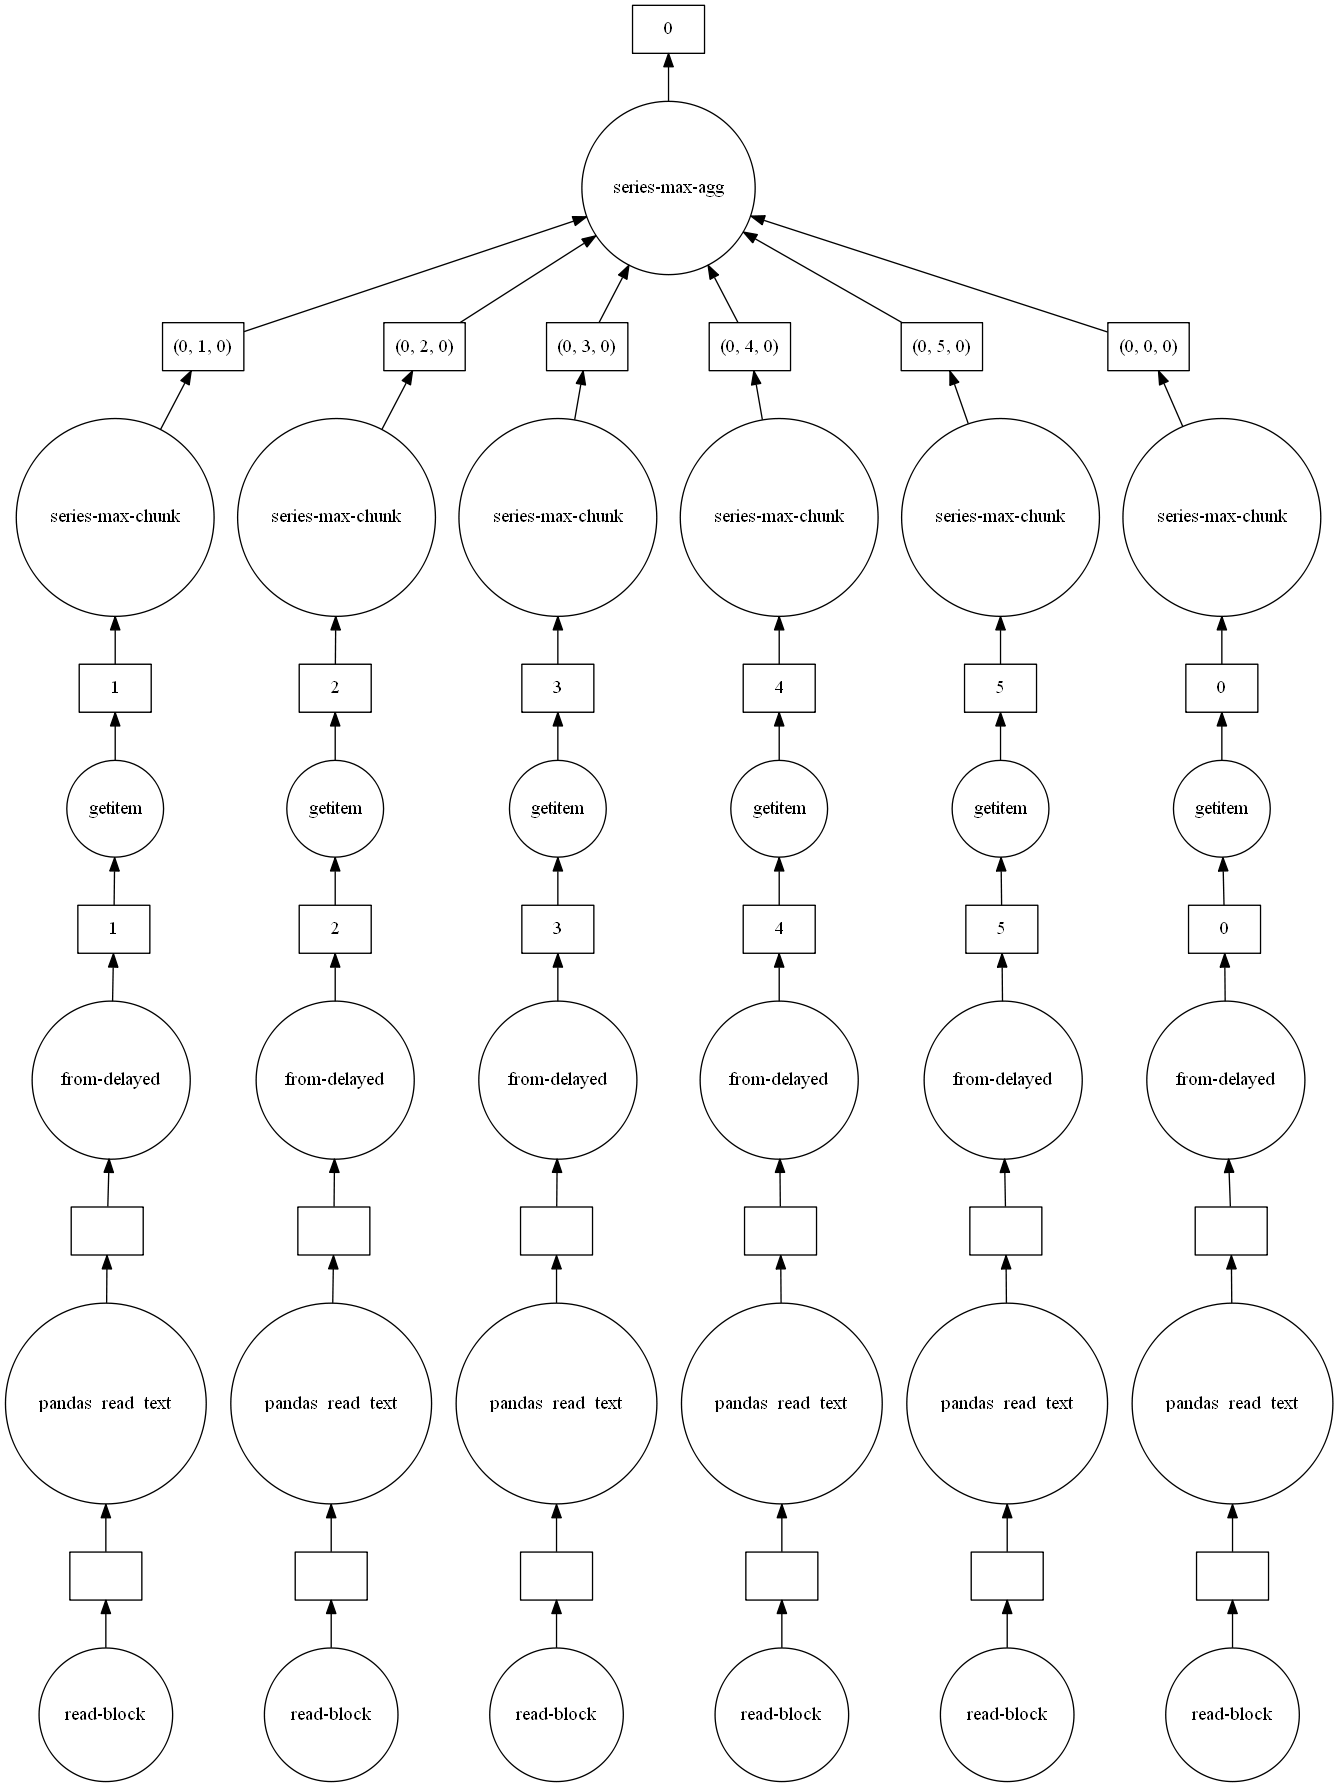

In [48]:
m.visualize()

In [11]:
%%time 
m.compute()

Wall time: 1.13 s


22686

In [12]:
%%time 
# сколько всего положительных значений:
len(df[df.amount > 0])

Wall time: 1.31 s


5050710

In [13]:
%%time 
(df.amount > 0).sum().compute()

Wall time: 1.13 s


5050710

#### Совместное использование промежуточных результатов

При работе с DataFrame некоторые вычисления могут проделываться более одного раза. Для большинства операций `dask.dataframe` сохранияет промежуточные результаты так, что они могут повторно использоваться. Но для этого эти промежуточные результаты должны рассматриваться в рамках одного процесса вычислений, запущенного вызовом `compute` (или его неявным аналогом).

Рассмотрим пример рассчета суммы и среднего значения для одного столбца `dask.dataframe`. 

In [14]:
df_sum = df[df.amount > 0].amount.sum()
df_mean = df[df.amount > 0].amount.mean()

In [15]:
%%time
df_sum.compute()

Wall time: 1.3 s


6448732337

In [16]:
%%time
df_mean.compute()

Wall time: 1.32 s


1276.7971902960178

Для рассчета среднего значения используется суммирование по столбцу, что и составляет основную трудоемкость операции. (не случайно выполнение каждой из функций занимает примерно одно время). Использование промежуточных результатов суммирования для вычисления среднего значения могло бы существенно его ускорить. Для этого обе функции нужно рассчитать в рамках одного вызова функции `compute`.

In [17]:
%%time
s, m  = dask.compute(df_sum, df_mean)
s, m

Wall time: 1.33 s


(6448732337, 1276.7971902960178)

Использование `dask.compute` для одновременного рассчета двух функций сократило время рассчета в 2 раза. Это произошло из-за того, что графы зависимостей задач для вычисления каждой функции были объеденины, что позволило однократно выполнять вычисления встречающиеся в каждом из графов.

В частности однократно выполнялись операции: 

* загрузка данных из файла (функция `read_csv`)
* фильтарция (`df[df.amount > 0]`)
* часть операций в свертках (функции `sum`, `count`)

Для того, чтобы увидеть как были объединены графы зависимостей задач можно исопльзовать функцию `dask.visualize` (для подробного рассмотрения графа можно использовать экспорт в pdf файл с помощью параметра `filename='graph.pdf'`)

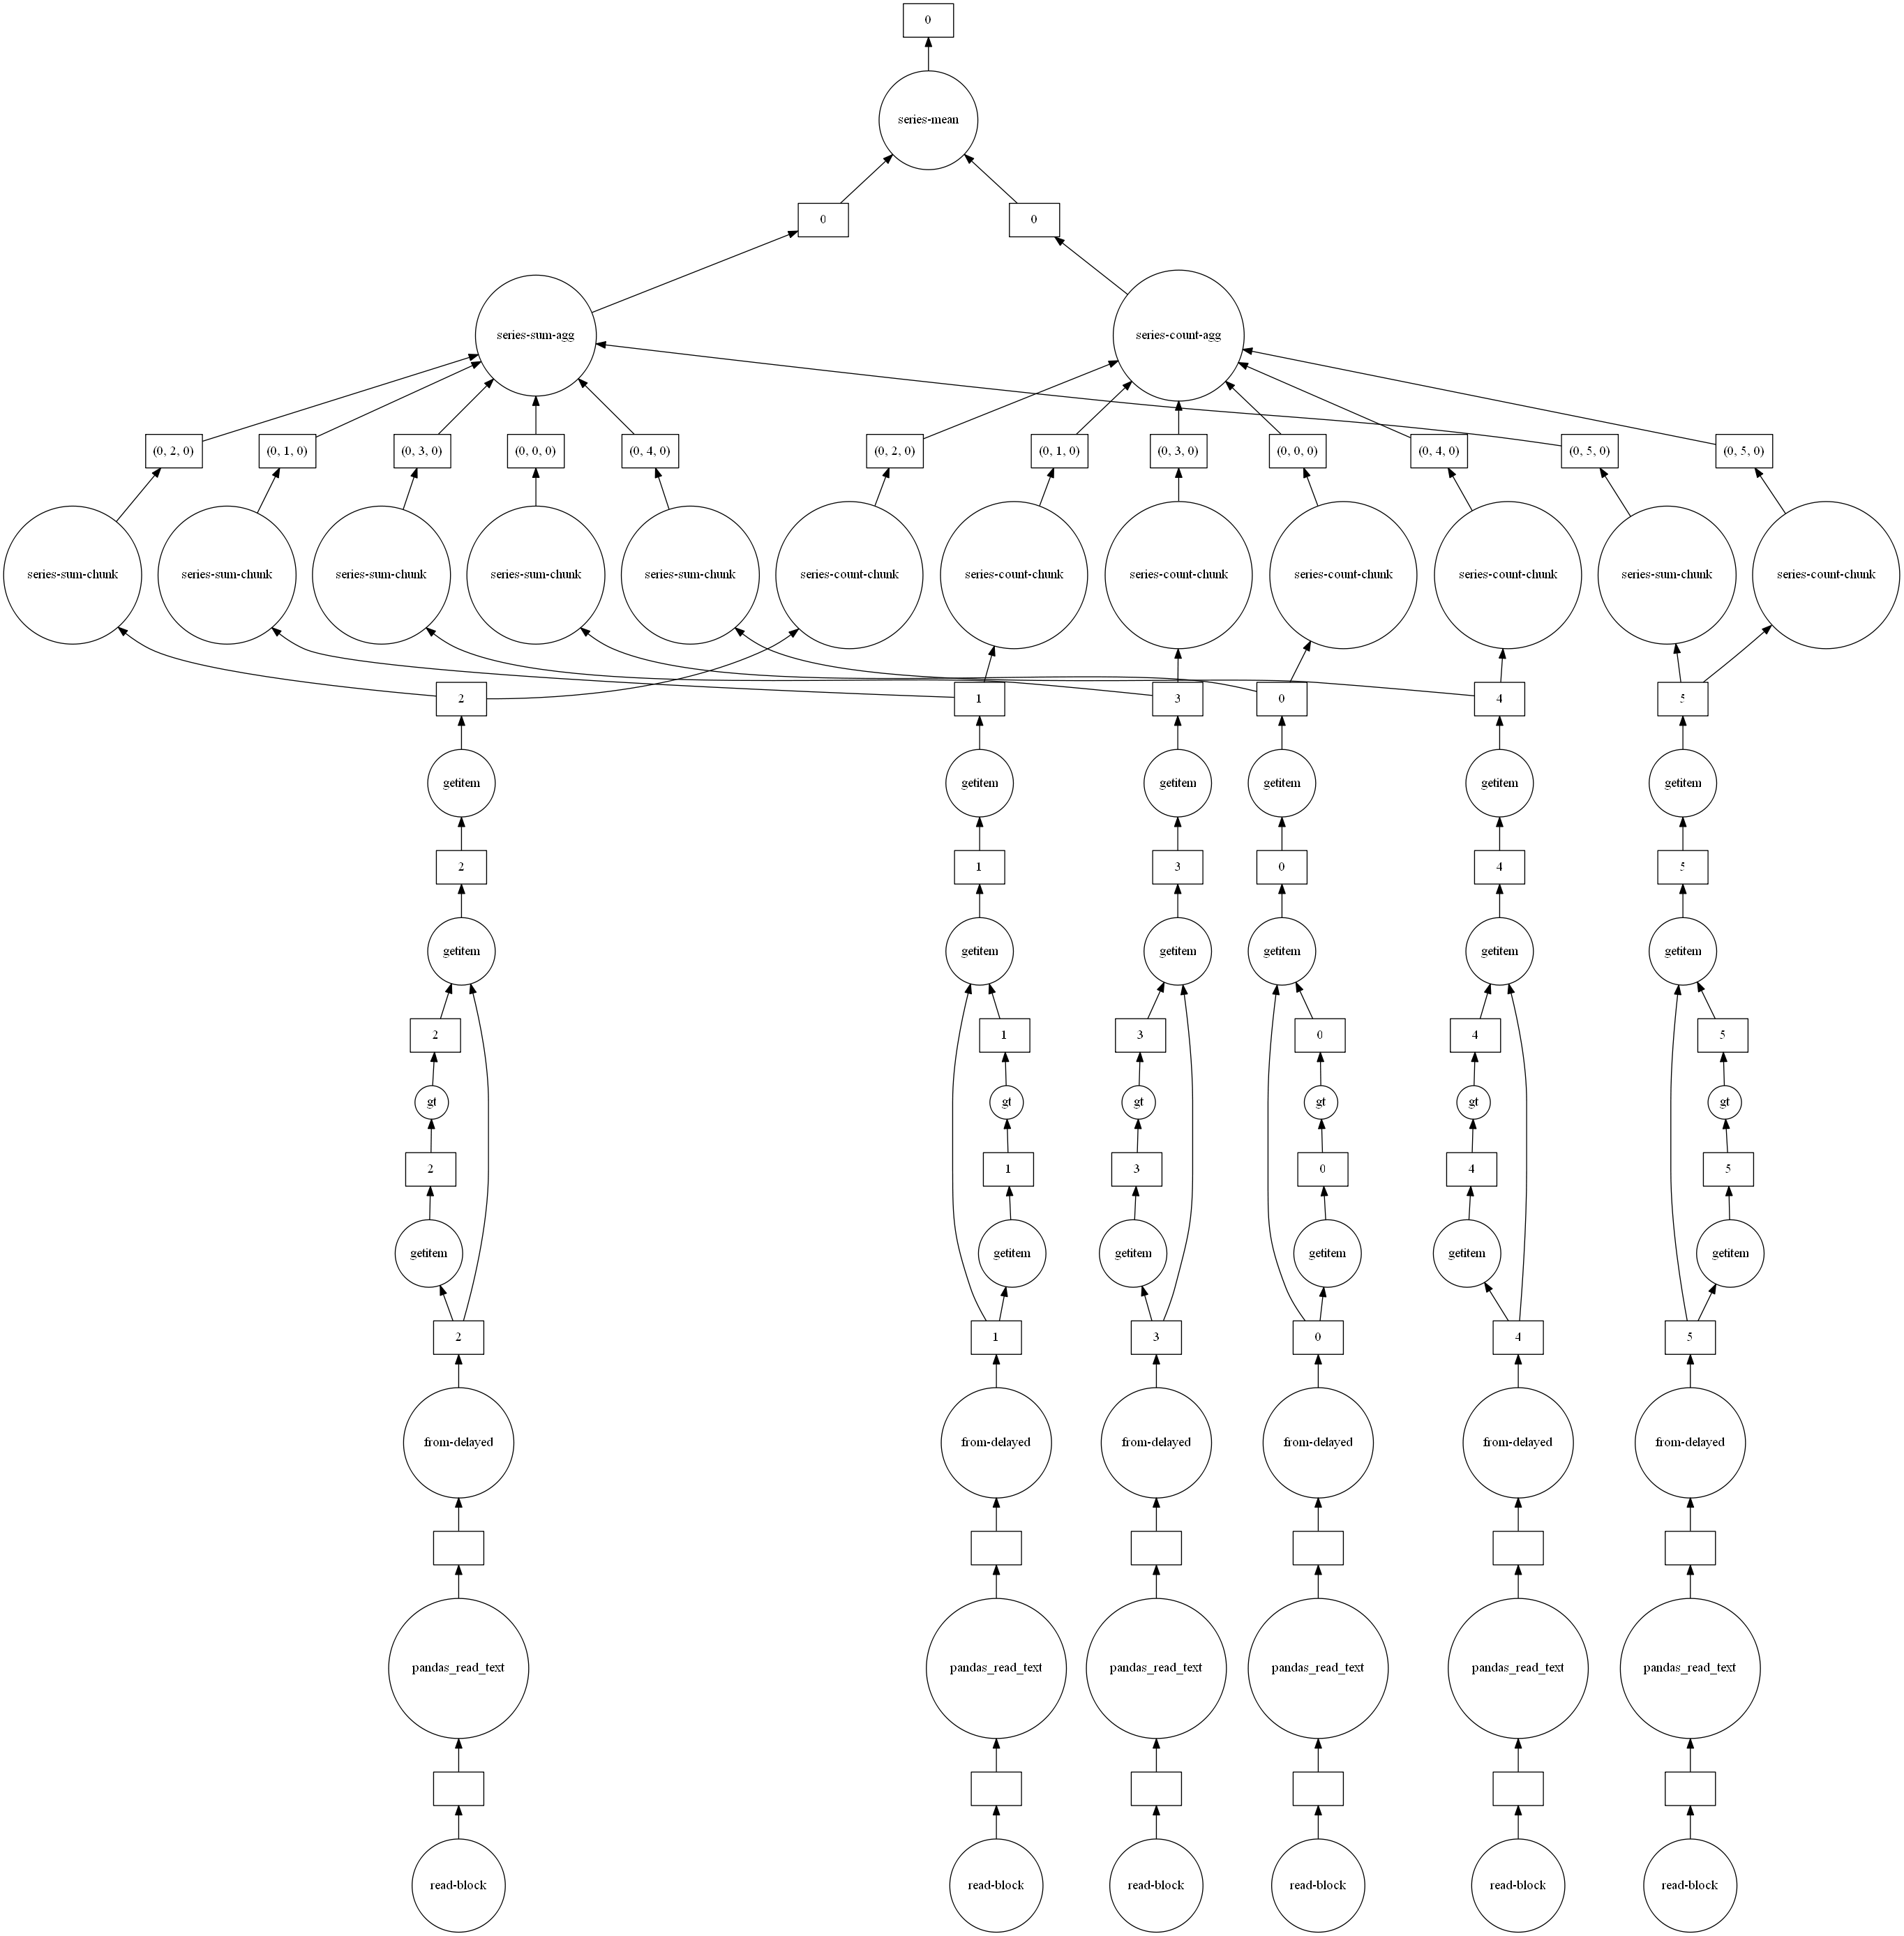

In [59]:
dask.visualize(df_sum, df_mean)

In [68]:
dask.visualize(df_sum, df_mean, filename='sum_mean_vis.pdf')

#### Mаппинг в Dask.DataFrame

В `dask.dataframe` есть несколько функций для применения собственных функций к данным, хранящихся в dataframe. Для работы с Series в Dask имеются следующие функции:

* `map` мэппинг значений из series используя сопосотавление из словаря, другой серии или функции
* `apply` применение более сложных функций к элементам из series
* `map_partitions` применение функции к каждой секции `Dask.DataFrame`
* `map_overlap` применение функции к каждой секции `Dask.DataFrame` с возможностью доступа к значениям из смежных секций.

`map(arg, na_action=None, meta='__no_default__')` мэппинг значений из series используя сопосотавление из словаря, другой серии или функции

Параметры:	
* arg: функция, словарь или серия - определяет преобразование элементов
* na_action: {None, ‘ignore’} при значении ‘ignore’, значения NA распространяеются без применения преобразования

`meta`: метаданные возвращаемого результата, определяющие структуру и типы столбцов возвращаемого значения, метаданные могут быть заданы одним из из типов: pd.DataFrame, pd.Series, dict, iterable, tuple, optional. Пустой pd.DataFrame или pd.Series имеющие последовательность, названия и типы столбцов (dtype) соответствующие возвращаемому значению. Альтернативой может быть словарь вида {name: dtype} или итерируемый объект состоящий из картежей (name, dtype). В случае отсутствия метаданных Dask попытается автоматически их определить, что может привести к непредвиденным ошибкам.

In [18]:
size = 8
abc = list(map(chr, range(ord('a'), ord('a') + size)))
abc

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

In [19]:
df1 = pd.DataFrame(data=list(zip(abc, [np.random.randint(5) for v in range(size)])), 
                   index=list(range(size)), columns=['val','rnd'])
df1

,val,rnd
0,a,3
1,b,2
2,c,3
3,d,0
4,e,1
5,f,4
6,g,2
7,h,1


In [20]:
ddf1 = dd.from_pandas(df1, npartitions=2)

In [21]:
ddf1.dtypes

val    object
rnd     int64
dtype: object

In [23]:
# если структура DataFrame не меняется, то в качесвте метаданных возвращаемого результата можно передать исходные данные
ddf2 = ddf1['val'].map(lambda v: v*2, meta=ddf1['val']).compute()
ddf2

0    aa
1    bb
2    cc
3    dd
4    ee
5    ff
6    gg
7    hh
Name: val, dtype: object

In [25]:
d = dict(zip(abc, map(ord, abc)))
d

{'a': 97, 'b': 98, 'c': 99, 'd': 100, 'e': 101, 'f': 102, 'g': 103, 'h': 104}

In [26]:
ddf3 = ddf1['val'].map(d, meta=('val', np.int64)).compute()
ddf3

0     97
1     98
2     99
3    100
4    101
5    102
6    103
7    104
Name: val, dtype: int64

In [27]:
ddf3.dtypes

dtype('int64')

In [72]:
df2 = pd.DataFrame(data=list(range(1, size*10, 10)), index=abc, columns=['new_val'])
df2

,new_val
a,1
b,11
c,21
d,31
e,41
f,51
g,61
h,71


In [29]:
ddf4 = ddf1['val'].map(df2['new_val'], meta=('val', np.int64)).compute()
ddf4

NameError: name 'df2' is not defined

------

`apply` позволяет передавать фиксированные значения в позиционные и именнованные параметры применяемой функции через аргумент `args` и произвольные именованные параметры `**kwds`.

In [74]:
def s_mult(s, m, end=''):
    return s * m + end

In [75]:
ddf1['val'].apply(s_mult, args=(3,), end='-', meta=ddf1['val']).compute()

0    aaa-
1    bbb-
2    ccc-
3    ddd-
4    eee-
5    fff-
6    ggg-
7    hhh-
Name: val, dtype: object

Для работы с DataFrame в Dask имеются следующие функции:

* `apply` применение функции по строкам
* `applymap` поэлементный мэппинг значений для всех значений в DataFrame
* `map_partitions` применение функции к каждой секции `Dask.DataFrame`
* `map_overlap` применение функции к каждой секции `Dask.DataFrame` с возможностью доступа к значениям из смежных секций
* `pipe` выполнение цепочки операций по применению функций к DataFrame, Series или объектам GroupBy 

In [30]:
def name_add(row, n_len, val=1):
    if len(row['names']) > n_len:
        row['amount'] += val
    return row

In [31]:
df.head(15)

,id,names,amount
0,419,Yvonne,148
1,247,Xavier,660
2,451,Patricia,1644
3,24,Oliver,126
4,71,Xavier,1296
5,396,Oliver,180
6,481,Michael,-407
7,199,Hannah,1943
8,92,Edith,782
9,75,Patricia,-157


In [32]:
df = dd.read_csv(filename,
                dtype={'id': int,
                        'names': str,
                        'amount': int})

In [33]:
# apply аналогична работе в DataFrame, но поддерживате работу только по строкам (axis=1)
df_a = df.apply(name_add, axis=1, args=(4,), val=1000, meta=df)

In [80]:
df_a.head()

,id,names,amount
0,419,Yvonne,1148
1,247,Xavier,1660
2,451,Patricia,2644
3,24,Oliver,1126
4,71,Xavier,2296


-----

`map_partitions(func, *args, **kwargs)` - применение функции к каждой секции `Dask.DataFrame`

Параметры:
func - функция, которая применяется к каждому Pandas.DataFrame
args, kwargs - параметры func. Среди kwargs может передаваться параметр meta, содержащий метаданные возвращаемого результата.

`map_partitions` может применяться для применения функций Pandas.DataFrame не реализованных в Dask или для исопользования удобных выражений Pandas для рассчетов.

In [10]:
df.dtypes

id         int32
names     object
amount     int32
dtype: object

In [34]:
df_mp = df.map_partitions(lambda df: df.assign(val=df.id + df.amount), 
                  meta={'id': 'i4', 'names': 'object', 'amount': 'i4', 'val': 'i4'})

In [35]:
r = df_mp.compute()
r.head()

,id,names,amount,val
0,419,Yvonne,148,567
1,247,Xavier,660,907
2,451,Patricia,1644,2095
3,24,Oliver,126,150
4,71,Xavier,1296,1367


In [36]:
# использование map_partitions для полученяи заголовков всех секторов:
df.map_partitions(pd.DataFrame.head, 3, meta=df).compute()

,id,names,amount
0,419,Yvonne,148
1,247,Xavier,660
2,451,Patricia,1644
0,75,Patricia,-45
1,421,Norbert,201
2,204,Wendy,3529
0,92,Edith,772
1,182,Hannah,-128
2,285,Zelda,2025
0,219,Jerry,4039


-----

`pipe(func, *args, **kwargs)` выполнение цепочки операций по применению функций к DataFrame, Series или объектам GroupBy. Aналогично `apply` применяет функцию `func` с аргументами `*args` и `**kwargs`. Позволяет последовательное применение функции записывать вместо вида: 

`f(g(h(df), arg1=a), arg2=b, arg3=c)`

в виде:

`(df.pipe(h)  
   .pipe(g, arg1=a)
   .pipe(f, arg2=b, arg3=c)
 )`

In [37]:
ddf1.head(8)

C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\core.py:5738: UserWarning: Insufficient elements for `head`. 8 elements requested, only 4 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


,val,rnd
0,a,3
1,b,2
2,c,3
3,d,0


In [28]:
def npow(a, b):
    return a ** b

In [29]:
# конструкция (npow, 'b') позволяет передавать данные не в первый аргумент функции:
ddf1['rnd'].pipe((npow, 'b'), a=2).pipe(operator.floordiv, 3).compute()

0    5
1    0
2    0
3    5
4    1
5    0
6    5
7    1
Name: rnd, dtype: int64

#### Rolling Operations

http://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.map_overlap

In [38]:
size = 10
df_r = pd.DataFrame({'x': list(range(1, size*2, 2)), 'y': list(range(size))})
df_r

,x,y
0,1,0
1,3,1
2,5,2
3,7,3
4,9,4
5,11,5
6,13,6
7,15,7
8,17,8
9,19,9


In [39]:
ddf_r = dd.from_pandas(df_r, npartitions=2)

In [40]:
ddf_r.map_overlap(lambda df: df.rolling(2).sum(), 2, 0).compute()

,x,y
0,NaN,NaN
1,4.0,1.0
2,8.0,3.0
3,12.0,5.0
4,16.0,7.0
5,20.0,9.0
6,24.0,11.0
7,28.0,13.0
8,32.0,15.0
9,36.0,17.0


In [41]:
ddf_r.map_overlap(lambda df: df.rolling(3, center=True).mean(), 1, 1).compute()

,x,y
0,NaN,NaN
1,3.0,1.0
2,5.0,2.0
3,7.0,3.0
4,9.0,4.0
5,11.0,5.0
6,13.0,6.0
7,15.0,7.0
8,17.0,8.0
9,NaN,NaN


#### GroupBy

In [42]:
%%time
df.groupby('id').id.count().compute()

Wall time: 1.19 s


id
0       9951
1       8058
2      17748
3      15241
4       4762
       ...  
495     5216
496    17576
497    11155
498     3924
499     2917
Name: id, Length: 500, dtype: int64

| Функция | Краткое описание |
|------|------|
|`DataFrameGroupBy.aggregate(arg[, …])'| Aggregate using one or more operations over the specified axis.
|`DataFrameGroupBy.apply(func, *args, **kwargs)'| Parallel version of pandas GroupBy.apply
|`DataFrameGroupBy.count([split_every, split_out])'| Compute count of group, excluding missing values
|`DataFrameGroupBy.cumcount([axis])'| Number each item in each group from 0 to the length of that group - 1.
|`DataFrameGroupBy.cumprod([axis])'| Cumulative product for each group
|`DataFrameGroupBy.cumsum([axis])'| Cumulative sum for each group
|`DataFrameGroupBy.get_group(key)'| Constructs NDFrame from group with provided name
|`DataFrameGroupBy.max([split_every, split_out])'| Compute max of group values
|`DataFrameGroupBy.mean([split_every, split_out])'| Compute mean of groups, excluding missing values
|`DataFrameGroupBy.min([split_every, split_out])'| Compute min of group values
|`DataFrameGroupBy.size([split_every, split_out])'| Compute group sizes
|`DataFrameGroupBy.std([ddof, split_every, …])'| Compute standard deviation of groups, excluding missing values
|`DataFrameGroupBy.sum([split_every, split_out])'| Compute sum of group values
|`DataFrameGroupBy.var([ddof, split_every, …])'| Compute variance of groups, excluding missing values
|`DataFrameGroupBy.first([split_every, split_out])'| Compute first of group values
|`DataFrameGroupBy.last([split_every, split_out])'| Compute last of group values

In [43]:
%%time
# сколько положительных значений для каждого из имен:
df[df.amount > 0].groupby('names').names.count().compute()

Wall time: 1.73 s


names
Alice       109527
Bob         239781
Charlie      85545
Dan         242913
Edith       104864
Frank       251796
George      137641
Hannah      159913
Ingrid      269959
Jerry       136608
Kevin       194267
Laura       157588
Michael     103967
Norbert     285504
Oliver      192972
Patricia    271816
Quinn       194767
Ray         183596
Sarah       287193
Tim         109200
Ursula      174331
Victor      223538
Wendy       294904
Xavier      304452
Yvonne      231395
Zelda       102673
Name: names, dtype: int64

In [36]:
%%time
# aggregage позволяет выполнить одновременно несколько агрегирующих операций при группировке:
df[df.amount > 0].groupby('names').amount.aggregage(['min', 'max']).compute()

AttributeError: 'SeriesGroupBy' object has no attribute 'aggregage'

In [37]:
# группировку можно производить при помощи функции, которая будет применяться к индексу:
df.groupby(lambda df_ind: df_ind % 10).amount.max().compute()

0    22686
1    21841
2    22468
3    21910
4    22637
5    21964
6    22298
7    21897
8    22322
9    21718
Name: amount, dtype: int32

In [38]:
df.groupby('names').amount.mean().compute()

names
Alice        195.943378
Bob         1536.908475
Charlie     1606.777283
Dan          714.396260
Edith        855.450165
Frank         67.929874
George      1209.325262
Hannah       608.245084
Ingrid       868.830291
Jerry        863.321936
Kevin        867.817306
Laura        394.396432
Michael     1541.045388
Norbert      667.258689
Oliver      1194.686210
Patricia    1364.664664
Quinn        327.435185
Ray          980.202169
Sarah       1403.236226
Tim          562.146067
Ursula      1773.548749
Victor       798.757834
Wendy       1004.839135
Xavier      1427.744374
Yvonne      1095.820447
Zelda       1797.110542
Name: amount, dtype: float64

TODO: from Dask Array

TODO: reindex

TODO: join
